In [200]:
# 資料處理

from finlab.data import Data

data = Data()

twii = data.get('發行量加權股價指數')
twse_bki = data.get('金融保險類指數')

import warnings 
warnings.filterwarnings('ignore') 

twii = twii[twii.index.second == 0]
twse_bki = twse_bki[twse_bki.index.second == 0]

twii = twii['台股指數']
twse_bki = twse_bki['台股指數']
twse_bki 

date
2006-01-02 09:00:00     891.39
2006-01-02 09:01:00     881.77
2006-01-02 09:02:00     881.67
2006-01-02 09:03:00     880.66
2006-01-02 09:04:00     879.87
                        ...   
2021-04-20 13:26:00    1472.39
2021-04-20 13:27:00    1472.39
2021-04-20 13:28:00    1472.39
2021-04-20 13:29:00    1472.39
2021-04-20 13:30:00    1476.09
Name: 台股指數, Length: 1021941, dtype: float64

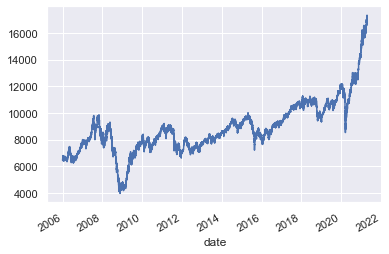

<AxesSubplot:xlabel='date'>

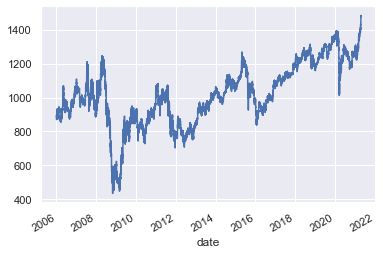

In [364]:
# 簡單趨勢示意圖

import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

twii.plot()

plt.show()

twse_bki.plot()

In [251]:
# 取得每日均價、轉換資料型態
import pandas as pd
import numpy as np
import datetime

mean_price_bki = twse_bki.groupby([twse_bki.index.date]).mean()
mean_price_twii = twii.groupby([twse_bki.index.date]).mean()

# mean_price_twii = twii.groupby([twii.index.year, twii.index.month, twii.index.date]).mean()
# mean_price_bki = twse_bki.groupby([twse_bki.index.year, twse_bki.index.month, twse_bki.index.date]).mean()

# mean_price_twii.index = mean_price_twii.index.set_names(['year', 'month', 'date'], level=[0, 1, 2])
# mean_price_bki.index = mean_price_bki.index.set_names(['year', 'month', 'date'], level=[0, 1, 2])


# mean_price_bki.index = pd.to_datetime(mean_price_bki.index)
# mean_price_bki
# mean_price_bki = mean_price_bki['year' == 2020]
# mean_price_bki.diff()


In [464]:
import statsmodels

from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import adfuller

# from statsmodels.tsa.statespace import SARIMAX


<Figure size 432x288 with 0 Axes>

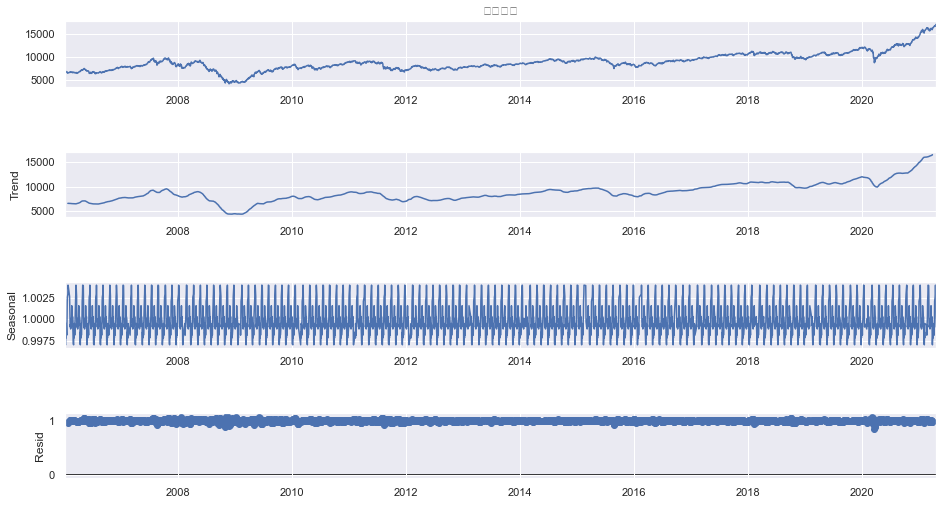

In [280]:
# 1. Visualize the data:確認資料穩定性、分解季節性因素


decomposition = seasonal_decompose(mean_price_twii, 'multiplicative', period=30)
# multiplicative: yt = St x Tt x Et

fig = plt.figure()  
fig = decomposition.plot()
fig.set_size_inches(15, 8)

# trend = decomposition.trend
# seasonal = decomposition.seasonal 
# residual = decomposition.resid



In [455]:
# ADF單根檢定法: 確認用來預測數據本身具穩定性(Stationary)
# http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/

# 取差分: -11
# twii_diff = mean_price_twii.diff()
# twii_diff = twii_diff.dropna()

# bki_diff = mean_price_bki.diff()
# bki_diff = bki_diff.dropna()

# 取對數: 無顯著性
twii_log = np.log(mean_price_twii)
twii_log = twii_log.dropna()
bki_log = np.log(mean_price_bki)
bki_log = bki_log.dropna()

# 取對數差分: -10
twii_logdiff = twii_log.diff()
twii_logdiff = twii_logdiff.dropna()
bki_logdiff = bki_log.diff()
bki_logdiff = bki_logdiff.dropna()

# df = pd.DataFrame([twii_diff, bki_diff], index=('twii', 'bki')).T
# df

In [525]:
from statsmodels.tsa.stattools import adfuller

def test_stationaity(timeseries, window):
    
    #Determing rolling statistics:
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()
    
    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    # plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Result of ADF: ')
    dftest = adfuller(timeseries)
    dftest = dftest
    dfoutput = pd.Series(dftest[0:4], index=['test statistis','p-value','lags used','numbers of observation'])
    for key, value in dftest[4].items():
        dfoutput['critical value (%s)'%key] = '{0:f}'.format(value)
        
        #dfoutput['critical value {:.3f}'.format(key)] = float(value)
    print(dfoutput)
    

In [526]:
adf = adfuller(bki_logdiff)
adf

(-10.909832389590624,
 1.1041408787860144e-19,
 28,
 3741,
 {'1%': -3.43209920949247,
  '5%': -2.8623129042084874,
  '10%': -2.5671814276580465},
 -22088.774098292317)

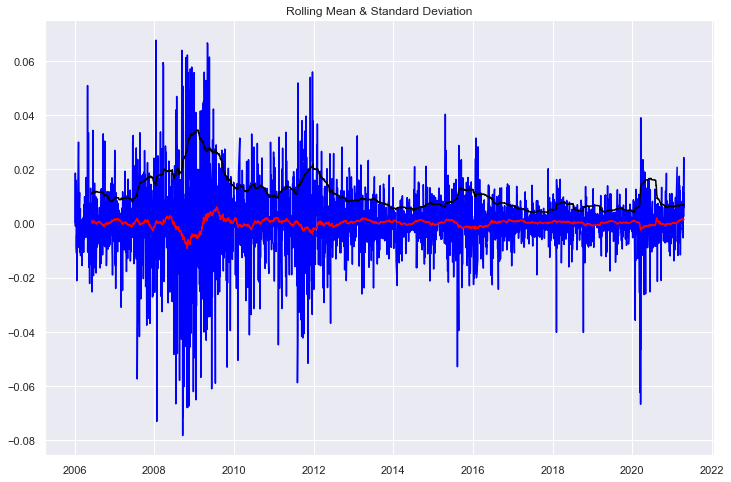

Result of ADF: 
test statistis               -10.9098
p-value                   1.10414e-19
lags used                          28
numbers of observation           3741
critical value (1%)         -3.432099
critical value (5%)         -2.862313
critical value (10%)        -2.567181
dtype: object


In [527]:
test_stationaity(bki_logdiff, window=100)

In [528]:
# 時間序列的都用granger causality test



In [529]:
def corr_index(ts1, ts2):  

    #Determing rolling statistics:
    corr5 = ts1.rolling(5).corr(ts2)
    corr10 = ts1.rolling(10).corr(ts2)
    corr30 = ts1.rolling(30).corr(ts2)
    corr100 = ts1.rolling(100).corr(ts2)
    df_corr = pd.DataFrame([corr5, corr10, corr30, corr100], index=['5days', '10days', '30days', '100days']).T.dropna(how='any')
    print(df_corr)
    

In [493]:
corr_index(twii_logdiff, bki_logdiff)    

               5days    10days    30days   100days
2006-06-05  0.150327  0.619085  0.751630  0.670955
2006-06-06  0.682179  0.765439  0.770802  0.693397
2006-06-07  0.848903  0.729094  0.771345  0.687901
2006-06-08  0.937150  0.825903  0.793882  0.703936
2006-06-09  0.913437  0.827889  0.791230  0.705884
...              ...       ...       ...       ...
2021-04-14  0.360001  0.156000  0.339347  0.480335
2021-04-15  0.664148  0.337915  0.381243  0.501655
2021-04-16  0.752864  0.405591  0.392370  0.505389
2021-04-19  0.810152  0.474662  0.386247  0.506956
2021-04-20  0.811036  0.609732  0.378695  0.505348

[3671 rows x 4 columns]
